In [1]:
import os
from pathlib import Path

import session_info

import pyrefinebio

import statistics
import pandas as pd
import numpy as np
import random

import seaborn as sns
sns.set_theme(color_codes=True)

import util.color_key as color_key

import matplotlib.pyplot as plt

In [3]:
random.seed(1234)

In [7]:
dirnames = ["data", "results", "plots"]

for dirname in dirnames:
        if not os.path.isdir(dirname):
                os.mkdir(dirname)

In [9]:
id = "SRP070849"

In [11]:
data_dir = Path(f"data/{id}")
data_file = data_dir.joinpath(f"{id}.tsv")
metadata_file = data_dir.joinpath(f"metadata_{id}.tsv")


In [15]:
if not data_file.exists() or not metadata_file.exists():
    print(f"Downloading {id} from refine.bio")
    pyrefinebio.create_token(agree_to_terms=True, save_token=False)
    pyrefinebio.download_dataset(
       data_dir.joinpath("dataset.zip"),
       "cansav09@gmail.com",
       experiments=[f"{id}"],
       extract=True,
    )

Creating Dataset...
Processing Dataset...


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\tmwer\\Documents\\JupyterLab\\python-heatmap-chapt-5\\data\\SRP070849\\dataset.zip'

In [19]:
metadata = pd.read_csv(metadata_file, sep="\t")

In [21]:
expression_df = pd.read_csv(data_file, sep="\t")

In [23]:
expression_df.set_index("Gene", inplace=True)

In [25]:
metadata.head(5)

,refinebio_accession_code,experiment_accession,refinebio_age,refinebio_cell_line,refinebio_compound,refinebio_disease,refinebio_disease_stage,refinebio_genetic_information,refinebio_organism,refinebio_platform,...,refinebio_processor_version,refinebio_race,refinebio_sex,refinebio_source_archive_url,refinebio_source_database,refinebio_specimen_part,refinebio_subject,refinebio_time,refinebio_title,refinebio_treatment
0,SRR3189679,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-1 RNA-Seq,none
1,SRR3189680,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-2 RNA-Seq,none
2,SRR3189681,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-3 RNA-Seq,none
3,SRR3189682,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,WT-4 RNA-Seq,none
4,SRR3189683,SRP070849,NaN,NaN,NaN,NaN,NaN,NaN,MUS_MUSCULUS,Illumina HiSeq 2000 (IlluminaHiSeq2000),...,v1.25.6-hotfix,NaN,NaN,NaN,SRA,lin-sca+ckit+,hematopoietic stem cells,NaN,IDH2.FLT3_veh_1 RNA-Seq,vehicle


In [27]:
print(metadata["refinebio_accession_code"].tolist() == expression_df.columns.tolist())

True


In [29]:
# Calculate the variance for each gene
expression_df["variance"] = expression_df.var(axis=1, skipna=True)

# Find the upper quartile for these data
upper_quartile = expression_df["variance"].quantile([0.90]).values

# Filter the data choosing only genes whose variances are in the upper quartile
df_by_var = expression_df[expression_df.variance > float(upper_quartile)]

# Drop the variance column we calculated
df_by_var = df_by_var.drop(columns="variance")

C:\Users\tmwer\AppData\Local\Temp\ipykernel_13372\312186437.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df_by_var = expression_df[expression_df.variance > float(upper_quartile)]


In [31]:
# Check how many genes we are left with
print(len(df_by_var.index))

4125


In [33]:
# Write df_by_var to tsv file
df_by_var.to_csv("results/top_90_var_genes.tsv", sep="\t")

In [35]:
# Recode refinebio_title variable into something more useful
# Split wherever there is a '-' or '.'
exp_group = metadata["refinebio_title"].str.split("-|\\.", expand=True, n=1)

In [37]:
# Now we'll store that first column from the string split back in the metadata as a column
metadata["exp_group"] = exp_group[0]

In [39]:
# Print to check
print(metadata["exp_group"])

0       WT
1       WT
2       WT
3       WT
4     IDH2
5     IDH2
6     IDH2
7     IDH2
8     IDH2
9     IDH2
10    IDH2
11    TET2
12    TET2
13    TET2
14    TET2
15    TET2
16    TET2
17    TET2
18    TET2
Name: exp_group, dtype: object


In [41]:
# Color code our two variables
refinebio_treatment_colors = color_key.make_color_key(metadata["refinebio_treatment"])
exp_groups_colors = color_key.make_color_key(metadata["exp_group"])

In [43]:
color_key_df = pd.concat(
    [refinebio_treatment_colors["color_key"], exp_groups_colors["color_key"]],
    axis=1,
    names=["treatment", "exp_group"],
)

color_key_df = color_key_df.set_index(df_by_var.columns)

In [45]:
# Check that this is what we think it is
color_key_df

,refinebio_treatment,exp_group
SRR3189679,#E30212,#221829
SRR3189680,#E30212,#221829
SRR3189681,#E30212,#221829
SRR3189682,#E30212,#221829
SRR3189683,#3B7000,#FB876E
SRR3189684,#3B7000,#FB876E
SRR3189685,#3B7000,#FB876E
SRR3189686,#BFE425,#FB876E
SRR3189687,#BFE425,#FB876E
SRR3189688,#BFE425,#FB876E


C:\Users\tmwer\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\tmwer\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


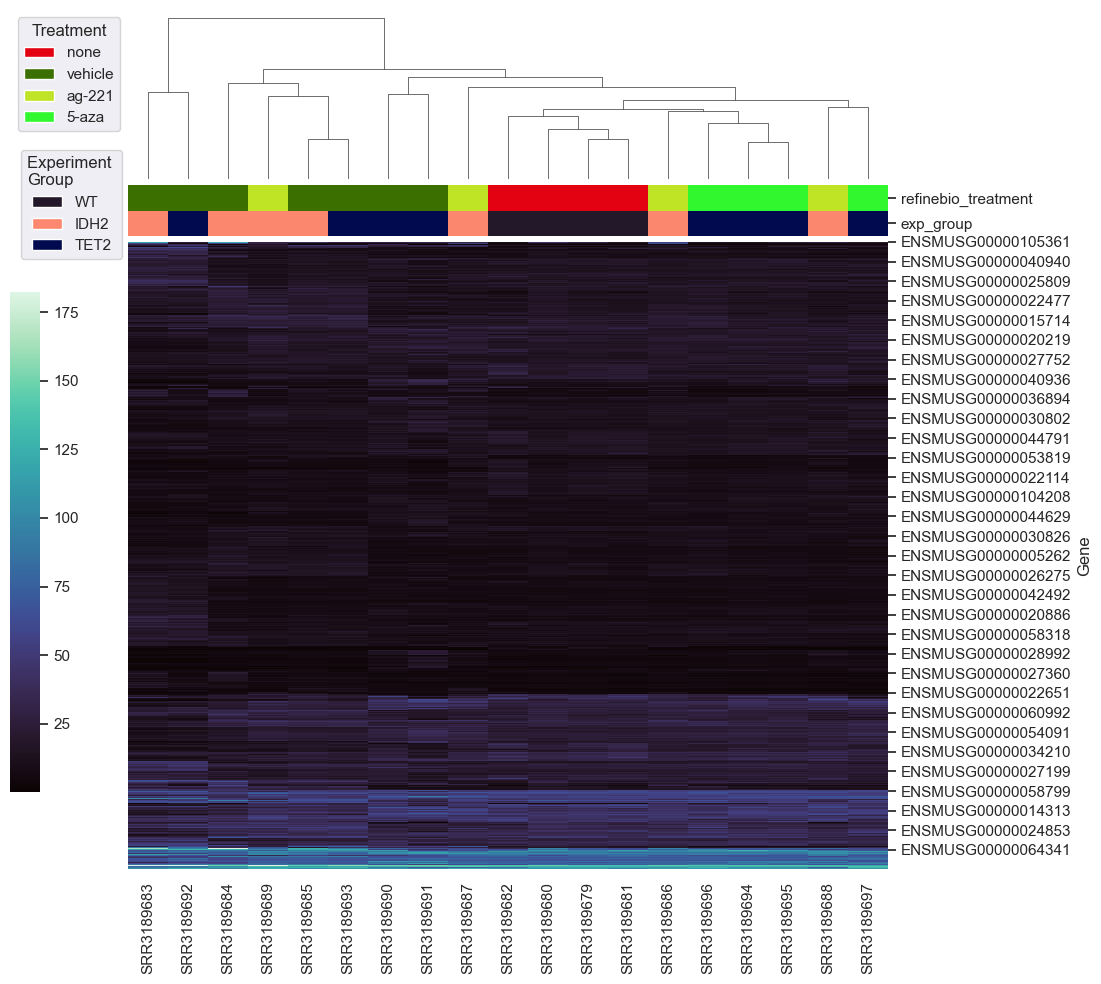

In [47]:
heatmap = sns.clustermap(
    df_by_var,
    cmap="mako",
    col_colors=color_key_df,
    dendrogram_ratio=(0, 0.2),
    cbar_pos=(-0.1, 0.2, 0.03, 0.5),
)

legend1 = color_key.make_legend(exp_groups_colors["color_key_dict"])
legend2 = color_key.make_legend(refinebio_treatment_colors["color_key_dict"])

# Make a legend 1
plt.legend(
    legend1,
    exp_groups_colors["color_key_dict"],
    title="Experiment \nGroup",
    bbox_to_anchor=(4, 1.3),
)

# Make a legend 2
heatmap.ax_row_dendrogram.legend(
    legend2,
    refinebio_treatment_colors["color_key_dict"],
    title="Treatment",
    bbox_to_anchor=(0, 1.37),
)

plt.show()

In [49]:
# Save to png
heatmap.savefig(os.path.join("plots", "aml_heatmap.png"))

In [51]:
session_info.show()